# Exploring the latent space of models
This notebook is an introduction to the concept of 'latent space' - a low-dimensional space in which datasets live and/or can be embedded. We've already constructed the ingredients for a deep latent space, using our autoencoders

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from tqdm import tqdm
from sklearn.manifold import TSNE
import re

tfk = tf.keras
tfkl = tfk.layers

# important for use on shared machine - comment these out if you're running locally.
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)

In [3]:
def load_image_from_path(path):
    """
    Decode a jpg image from the string filepath

    :param path: Path to image
    :return: 3D image tensor
    """
    raw_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(raw_img, channels=3)
    img = tf.image.convert_image_dtype(img, 'float32') # pre-normalises to 0,1

    return img.numpy()

### Loading in the trained model
Here we re-load the model we serialised from the previous notebook

In [4]:
model = tf.keras.models.load_model("autoenc.keras")
model.summary()

Model: "autoenc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ code (MaxPooling2D)             │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,819 (139.92 KB)

 Trainable params: 11,939 (46.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,880 (93.29 KB)

### How do our reconstructions look?
* Here we'll load in the validation data, encode the inputs, and look at how well we can reconstruct our galaxies

In [5]:
filepaths = glob.glob("data/final_28x28_proc/VAL/*.jpg")
imgs = np.array([load_image_from_path(r) for r in tqdm(filepaths, desc='Loading images', total=len(filepaths))])

# This could take a while without GPU.
reconst = model.predict(imgs, verbose=1, batch_size=128)

Loading images: 100%|██████████| 1539/1539 [00:00<00:00, 3237.63it/s]


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Text(0.5, 1.0, 'Reconst.')

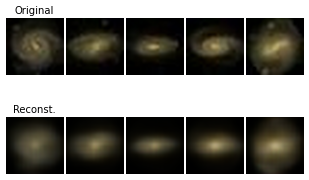

In [6]:
# plot some inputs and their reconstructions.
N_PANELS = 5
fig, ax = plt.subplots(2, N_PANELS, dpi=60)
plt.subplots_adjust(wspace=0.05, hspace=-0.2)

for i, idx in enumerate(np.random.randint(0, len(imgs), N_PANELS)):
    for j, arr in enumerate([imgs, reconst]):
        ax[j][i].imshow(arr[idx], interpolation='lanczos')
        ax[j][i].axis("off")

ax[0][0].set_title("Original")
ax[1][0].set_title("Reconst.")

### Model surgery
* In this next cell, we chop off the decoder of the model, and simply extract the 'embedding'/'code' layer. This contains the compressed representation of the input data we trained the model for.

In [7]:
# Compute the latent encodings from the autoencoder for the first 1024 stamps.
encoder = tfk.Model(inputs=model.input, outputs=model.get_layer('code').output)
testvecs = np.array(encoder(imgs)).reshape(len(imgs), -1)

print(f"Embedding shape is {testvecs.shape}")

Embedding shape is (1539, 128)


### Nearest-neighbour sanity check
* Given a chosen image, do the nearest neighbours in latent space look similar? The answer should be yes, but worth checking before we proceed.

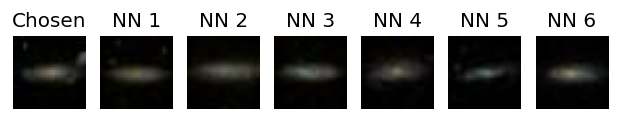

In [8]:
chosen_idx = 42
N_NEAREST_NEIGHBOURS = 6

fig, ax = plt.subplots(1, N_NEAREST_NEIGHBOURS+1, dpi=120)
ax[0].imshow(imgs[chosen_idx])
ax[0].axis("off")
ax[0].set_title("Chosen")

# find N nearest neighbours in latent space according to Euclidean distance.
nn_idxs = np.argsort(np.linalg.norm(testvecs[chosen_idx] - testvecs, axis=1))[1:N_NEAREST_NEIGHBOURS+1]

for i, nn_idx in enumerate(nn_idxs):
    ax[i+1].imshow(imgs[nn_idx])
    ax[i+1].axis("off")
    ax[i+1].set_title("NN {}".format(i+1))

plt.show()

### Unsupervised clustering
* Can we group galaxies based on their latent vectors? 
* Try two clustering methods, both don't require a set number of clusters. What sub-groupings can we find in the data?

**NB** this section is largely experimental - we can discuss during the workshop.

In [9]:
from sklearn.cluster import DBSCAN, OPTICS
clusterer = DBSCAN(min_samples=5).fit(testvecs)

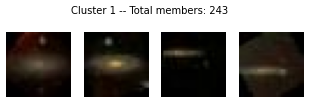

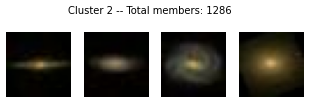

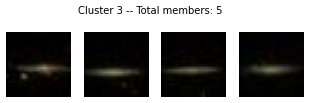

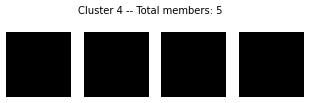

In [10]:
N_EXAMPLES_PER_CLUSTER = 4

for n in np.unique(clusterer.labels_):
    members = np.argwhere(clusterer.labels_ == n).flatten()
    
    fig, ax = plt.subplots(1, N_EXAMPLES_PER_CLUSTER, dpi=60)
    fig.suptitle("Cluster {} -- Total members: {}".format(n+2, len(members)), y=0.7)
    for i, idx in enumerate(np.random.choice(members.flatten(), N_EXAMPLES_PER_CLUSTER, replace=False)):
        ax[i].imshow(imgs[idx])
        ax[i].axis("off")

In [11]:
clusterer = OPTICS(min_samples=5).fit(testvecs)

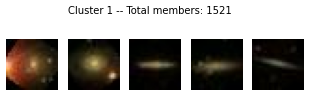

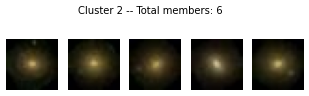

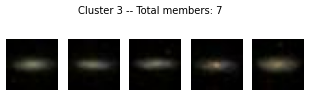

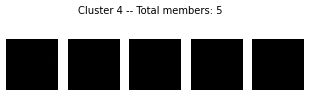

In [12]:
N_EXAMPLES_PER_CLUSTER = 5

for n in np.unique(clusterer.labels_):
    members = np.argwhere(clusterer.labels_ == n).flatten()
    
    fig, ax = plt.subplots(1, N_EXAMPLES_PER_CLUSTER, dpi=60)
    fig.suptitle("Cluster {} -- Total members: {}".format(n+2, len(members)), y=0.7)
    for i, idx in enumerate(np.random.choice(members.flatten(), N_EXAMPLES_PER_CLUSTER, replace=False)):
        ax[i].imshow(imgs[idx])
        ax[i].axis("off")

plt.show()

### For you to try:
* How does something like K-means (hint: `sklearn.cluster.KMeans`) perform?

### The problem
* End up in the regime with one large cluster, and many smaller clusters. If we set the minimum number of clusters too low, we end up with unrepresentative clusters.
* Solution: hierarchical clustering. This essentially builds clusters from the bottom up, with clusters being merged if a certain metric (here Ward linkage) is met. This means that clusters do not end up with such disparate sizes.

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [14]:
connectivity_matr = kneighbors_graph(testvecs, n_neighbors=4, mode='connectivity')
clusterer = AgglomerativeClustering(n_clusters=5, connectivity=connectivity_matr).fit(testvecs)

/Users/thkill/teaching/sdss_galaxy_unsupervised/venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


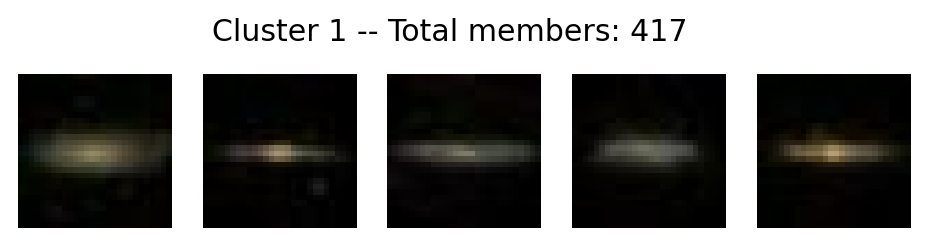

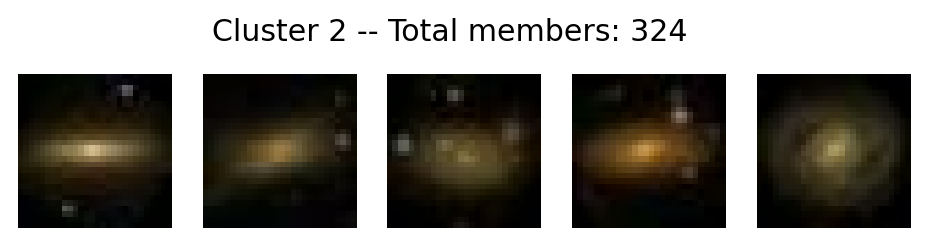

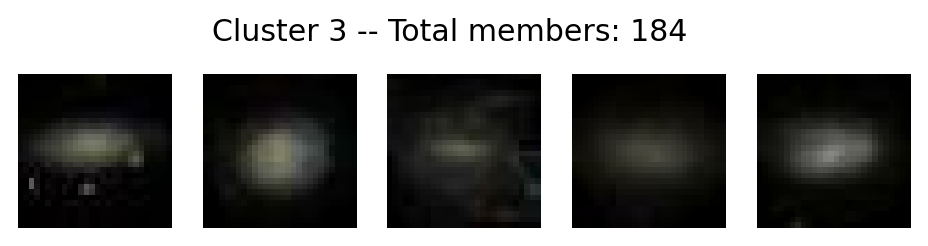

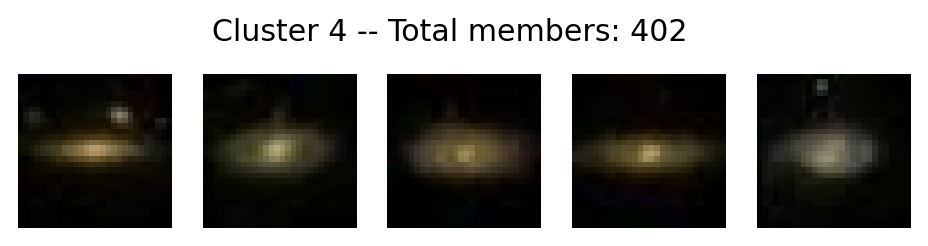

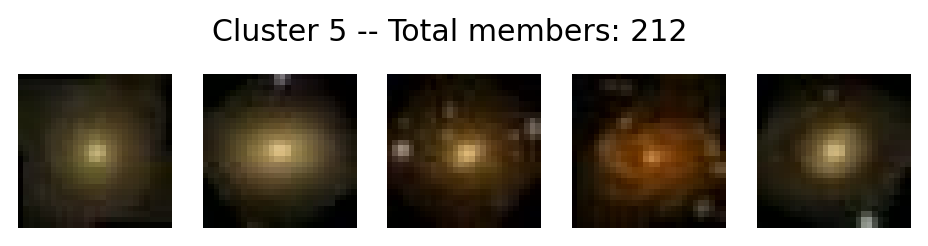

In [15]:
N_EXAMPLES_PER_CLUSTER = 5
for n in np.unique(clusterer.labels_):
    members = np.argwhere(clusterer.labels_ == n).flatten()
    
    fig, ax = plt.subplots(1, N_EXAMPLES_PER_CLUSTER, dpi=180)
    fig.suptitle("Cluster {} -- Total members: {}".format(n+1, len(members)), y=0.65)
    for i, idx in enumerate(np.random.choice(members.flatten(), N_EXAMPLES_PER_CLUSTER, replace=False)):
        ax[i].imshow(imgs[idx])
        ax[i].axis("off")


### For you to try:
* Agglomerative clustering is just one of these hierarchical clustering methods - try implementing HDBSCAN (hint `sklearn.cluster.HDBSCAN`) and see how it does.

### Does our clustering map in any way to morphology?
* Let's take the galaxies with morphological information, strip away the subtypes and make some broad classes. 
  * E: ellipticals
  * SB: barred spirals
  * S: regular spirals
  * Irr: irregulars -- not any of the above


In [16]:
morphology = np.array([f.split("/")[-1][:-4].split("_")[-1] for f in filepaths])

def amend_morphology_str(morphstr):
    # Merge all ellipticals into one class
    if re.search("E.", morphstr):
        return "E"
    
    # Merge all barred spirals into one class
    if re.search("SB.", morphstr):
        return "SB"
    
    # Move transitional spirals into Irregular
    if re.search("Sm", morphstr):
        return "Irr"
    
    # All spirals in the same class
    if re.search("S.", morphstr):
        return "S"
    
    else:
        return morphstr
    
morphology_corr = np.array([amend_morphology_str(s) for s in morphology])

E: 74 of 1539
Irr: 29 of 1539
NA: 751 of 1539
S: 543 of 1539
SB: 142 of 1539
Example morphology classes


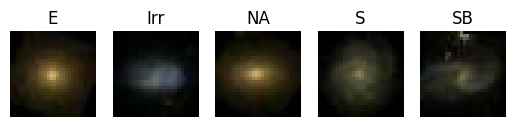

In [17]:
for m in np.unique(morphology_corr):
    print("{}: {} of {}".format(m, (morphology_corr == m).sum(), len(morphology_corr)))
    
fig, ax = plt.subplots(1, len(np.unique(morphology_corr)))

print("Example morphology classes")
for i, m in enumerate(np.unique(morphology_corr)):
    idx = np.random.choice(np.argwhere(morphology_corr == m).flatten())
    ax[i].imshow(imgs[idx])
    ax[i].set_title(m)
    ax[i].axis("off")

In [18]:
for c in np.unique(clusterer.labels_):
    mask1 = (clusterer.labels_ == c) 
    mask2 = mask1 & (morphology_corr != "NA")
    print("Cluster {}: {} of {}".format(c+1, mask2.sum(), mask1.sum()))
    for m in np.unique(morphology_corr):
        morph_mask = morphology_corr[mask2] == m
        print("{:.1f} % of all {}".format(100*morph_mask.sum() / (morphology_corr == m).sum(), m))
        

Cluster 1: 206 of 417
2.7 % of all E
27.6 % of all Irr
0.0 % of all NA
32.2 % of all S
14.8 % of all SB
Cluster 2: 154 of 324
14.9 % of all E
10.3 % of all Irr
0.0 % of all NA
19.5 % of all S
23.9 % of all SB
Cluster 3: 128 of 184
1.4 % of all E
58.6 % of all Irr
0.0 % of all NA
11.4 % of all S
33.8 % of all SB
Cluster 4: 185 of 402
2.7 % of all E
3.4 % of all Irr
0.0 % of all NA
28.0 % of all S
21.1 % of all SB
Cluster 5: 115 of 212
78.4 % of all E
0.0 % of all Irr
0.0 % of all NA
8.8 % of all S
6.3 % of all SB


### Do we really succeed here? Are any clusters overwhelmingly containing more of one type than another?

### t-SNE
* Let's apply [t-stochastic neighbour embedding](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) to reduce the dimensionality of the latent vectors. How well can we split the classes in this view? This is a bit like a non-linear PCA, which maps high-dimensional spaces to low-dimensional ones.

In [21]:
tsne_vecs = TSNE(perplexity=200, n_jobs=-1, verbose=1).fit_transform(testvecs)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1539 samples in 0.001s...
[t-SNE] Computed neighbors for 1539 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1539
[t-SNE] Computed conditional probabilities for sample 1539 / 1539
[t-SNE] Mean sigma: 0.317369
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.186546
[t-SNE] KL divergence after 1000 iterations: 0.567702


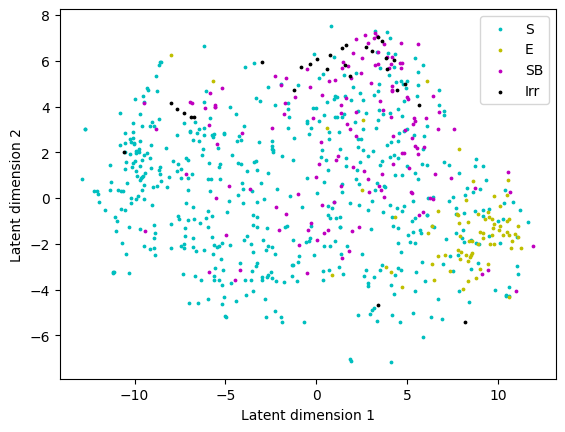

In [22]:
classes = ["S", "E", "SB", "Irr"]
colors = ["c", "y", "m", "k"]
for c, col in zip(classes, colors):
    mask = morphology_corr == c
    plt.scatter(tsne_vecs[mask,0], tsne_vecs[mask,1], s=3, c=col, label=c)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.legend()

### How did we do?
* There is a clear splitting between ellipticals and spirals.
* Splitting barred and unbarred spirals much harder - maybe this is a resolution issue?
* Irregulars broadly lie on the edge of the point cloud -- they are irregular!

##### Despite the not exceptional performance, let's explore some clustering metrics

In [25]:
# convert morphology strings into labels
morph_labels = morphology_corr[morphology_corr != "NA"]
morph_labels[morph_labels == "E"] = 0
morph_labels[morph_labels == "S"] = 1
morph_labels[morph_labels == "SB"] = 2
morph_labels[morph_labels == "Irr"] = 3
clust_labels = clusterer.labels_[morphology_corr != "NA"]

In [26]:
from sklearn import metrics

print("Silhouette score: {:.3f}".format(metrics.silhouette_score(testvecs, clusterer.labels_)))
print("Mutual information score: {:.3f}".format(metrics.mutual_info_score(morph_labels, clust_labels)))

Silhouette score: 0.117
Mutual information score: 0.176


### So what is the takeaway here?
* Non-linear dimensionality reduction is more powerful, but more involved.
* Clustering: not guaranteed to generate meaningful representations (why?)